Unsupervised Clustering
-----------------------

- K-means
- Affinity Propagation
- Mean Shift
- Spectral Clustering
- Hierarchical Clustering
- Agglomerative Clustering (hierarchical)
- Ward Clustering (hierarchical) - [notebook](#Ward-clustering)


Look at [clustering with and without structure](http://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-py).

Spectral clustering note
------------------------

[From sklearn api docs](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html):
"If you have an affinity matrix, such as a distance matrix, for which 0 means identical elements, and high values means very dissimilar elements, it can be transformed in a similarity matrix that is well suited for the algorithm by applying the Gaussian (RBF, heat) kernel:"
    
    np.exp(- dist_matrix ** 2 / (2. * delta ** 2))
    
Where `delta` is a free parameter representing the width of the Gaussian kernel.


k-means note
------------

k-means does not support distance matrices. What does it expect? Raw data?


Examples
--------

- [t-sne](https://github.com/oreillymedia/t-SNE-tutorial)
- [image classification](http://cs231n.github.io/classification/)

In [1]:
%matplotlib inline
from __future__ import division, print_function

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from sklearn.feature_extraction import image
from sklearn.metrics import pairwise, silhouette_score
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

/om/user/jakubk/jakub_env/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Load data and find good axial slice

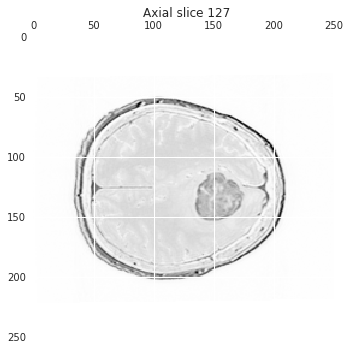

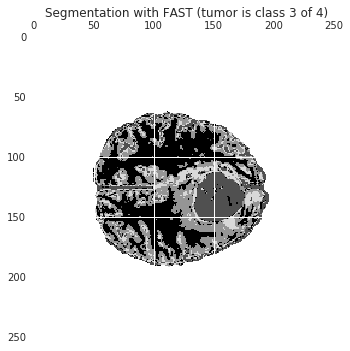

In [2]:
# # On local machine.
# brain = nib.load('data/case_005_2.nii.gz')
# seg = nib.load('data/case_005_2_brain_seg_fast.nii.gz')

# On OpenMind.
brain = nib.load('../data/case_005_2.nii.gz')
seg = nib.load('../segmentation/fast/brain/classes_4/case_005_2_brain_seg.nii.gz')

brain = brain.get_data()
# Segmentation done by FSL's FAST with 4 classes on an extracted brain (with ANTs).
seg = seg.get_data()

# Scale to range [0, 1]
# arr = np.divide(arr, arr.max())

slice_ = 127
b_slice = brain[:, :, slice_]
s_slice = seg[:, :, slice_]

plt.matshow(brain[:, :, slice_])
plt.title("Axial slice {}".format(slice_))
plt.matshow(seg[:, :, slice_])
plt.title("Segmentation with FAST (tumor is class 3 of 4)")

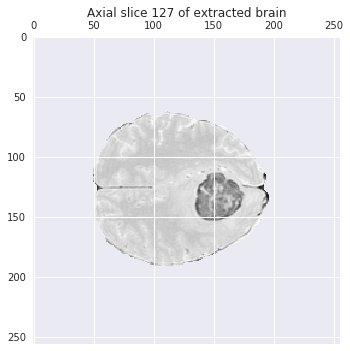

In [3]:
# Apply mask to remove skull.
b_slice_masked = np.ma.masked_array(b_slice, mask=~s_slice.astype(bool))
plt.matshow(b_slice_masked)
plt.title("Axial slice {} of extracted brain".format(slice_))

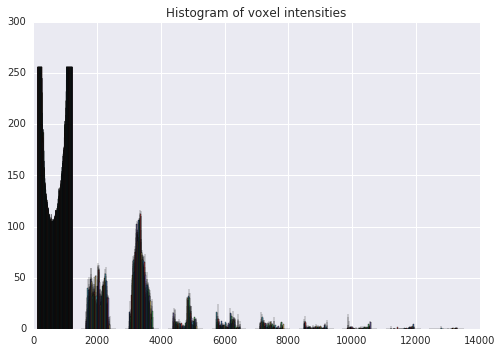

In [4]:
# Plot histogram.
# Tumor is roughly between intensities 4000 and 5500.
# Range includes some non-extracted meninges?
plt.hist(b_slice_masked)
plt.title("Histogram of voxel intensities")

# # Plot a range of intensities.
# plt.matshow(np.where((b_slice > 4000) & (b_slice < 5500), b_slice, np.nan))

# t-SNE

[example on github](https://github.com/oreillymedia/t-SNE-tutorial)

## Functions to approximate skull, brain, and meningioma

In [5]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html

# Define color palette.
palette = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

def make_synthetic_slice(dim, with_tumor=False):
    """Return array with shape (dim, dim) that approximates skull, brain, 
    and, if specified, tumor.
    dim: length of one side of the square array.
    with_tumor: whether tumor should be present in output array.
    """
    x, y = np.indices((dim, dim))
    # Define centers of circles.
    skull_cen = (dim // 2, dim // 2)
    brain_cen = skull_cen
    tumor_cen = (dim // 2 - dim // 2 * 0.35, dim // 2 + dim // 2 * 0.4)
    # Define radii.
    skull_rad, brain_rad, tumor_rad = dim // 2, dim // 2 * 0.8, dim // 2 * 0.25
    # Create boolean arrays to represent brain and tumor.
    skull = (x - skull_cen[0]) ** 2 + (y - skull_cen[1]) ** 2 < skull_rad ** 2
    brain = (x - brain_cen[0]) ** 2 + (y - brain_cen[1]) ** 2 < brain_rad ** 2
    tumor = (x - tumor_cen[0]) ** 2 + (y - tumor_cen[1]) ** 2 < tumor_rad ** 2

    # Convert to int32 so addition will lead to unique classes.
    skull = skull.astype(np.int32)
    brain = brain.astype(np.int32)
    tumor = tumor.astype(np.int32)

    # Add together to make complete image.
    if with_tumor:
        return (skull + brain + tumor)
    else:
        return (skull + brain)

def add_noise(arr, spots, random_state=None):
    """Add noise to a 2-D array.
    arr: array to which noise is added.
    spots: (int) number of spots of added noise. Can exceed arr dims.
    random_state: number to set the random seed."""
    np.random.seed(random_state)
    x_dim = arr.shape[0]
    y_dim = arr.shape[1]
    noise = np.zeros((x_dim, y_dim))
    for _ in range(spots):
        x_rand = np.random.randint(low=0, high=x_dim)
        y_rand = np.random.randint(low=0, high=y_dim)
        noise[x_rand, y_rand] = np.random.random()
    return arr.astype(np.float64) + noise

def make_X_y(arr):
    """Return X and y arrays from 2-D image array."""
    X = arr.flatten().reshape(-1, 1)
    y = np.floor((X).flatten())
    return X, y.astype(np.int32)

## Verify that t-SNE works on synthetic example

Shapes
X: (625, 1)
y: (625,)


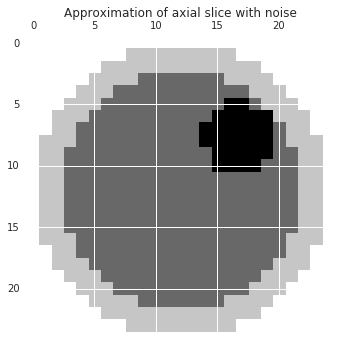

In [6]:
img = make_synthetic_slice(25, with_tumor=True)
# img = add_noise(img, 5000)

plt.matshow(img)
plt.title("Approximation of axial slice with noise")

X, y = make_X_y(img)
print("Shapes\nX: {}\ny: {}".format(X.shape, y.shape))

Shape of similarity matrix: (625, 625)
Shape of t-SNE output: (625, 2)


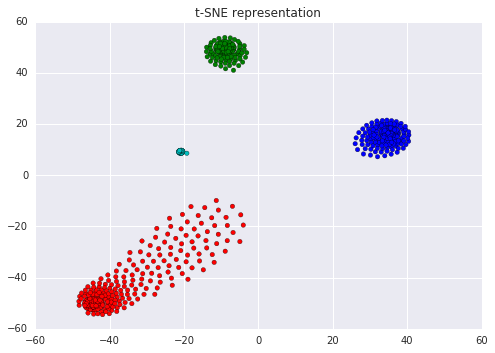

In [7]:
# Compute similarity matrix.
# X_sim = pairwise.cosine_similarity(X)
X_sim = pairwise.laplacian_kernel(X)
print("Shape of similarity matrix: {}".format(X_sim.shape))

# Perform t-SNE.
X_tsne = TSNE(perplexity=30, learning_rate=1000.).fit_transform(X_sim)
print("Shape of t-SNE output: {}".format(X_tsne.shape))

# Plot t-SNE representation.
palette = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[y])
plt.title("t-SNE representation")
plt.show()

## t-SNE on multiple similarity matrices

In [8]:
# Define the functions we want to test with t-SNE.
pairwise_funcs = [('raw data', None),
                  ('cosine distance', pairwise.cosine_distances),
                  ('cosine similarity', pairwise.cosine_similarity),
                  ('laplacian kernel', pairwise.laplacian_kernel),
                  ('euclidian distances', pairwise.euclidean_distances),
                  ('manhattan distances', pairwise.manhattan_distances),
                  ('sigmoid kernel', pairwise.sigmoid_kernel),
                  ('pairwise distances', pairwise.pairwise_distances),
                  ('linear kernel', pairwise.linear_kernel),
                  ('pairwise kernels', pairwise.pairwise_kernels),
                  ('rbf kernel', pairwise.rbf_kernel),
                  ('additive chi2 kernel', pairwise.additive_chi2_kernel),
                  ('chi2 kernel', pairwise.chi2_kernel),
                 ]
len(pairwise_funcs)

13

### Ideal case (noiseless brain)

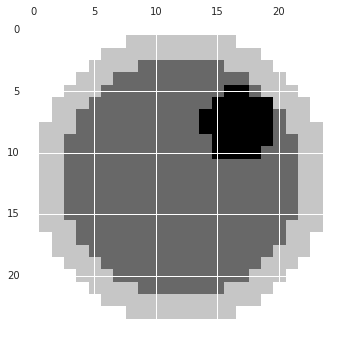

In [9]:
# Make a brain slice.
img = make_synthetic_slice(25, with_tumor=True)
X, y = make_X_y(img)
plt.matshow(img)

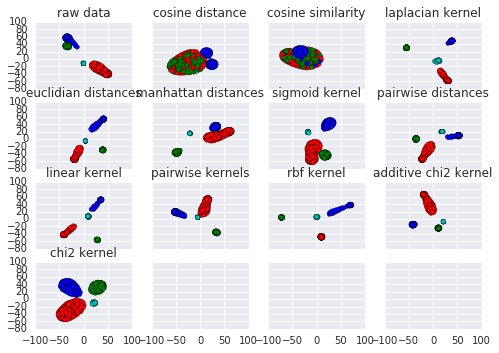

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
for (name, func), ax in zip(pairwise_funcs, axes.flatten()):
    if func is None:
        X_sim = X.copy()  # Just a copy of the raw image values.
    else:
        X_sim = func(X)
    X_tsne = TSNE(perplexity=30, learning_rate=1000.).fit_transform(X_sim)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[y])
    ax.set_title(name)
plt.show()

### Noisy brain

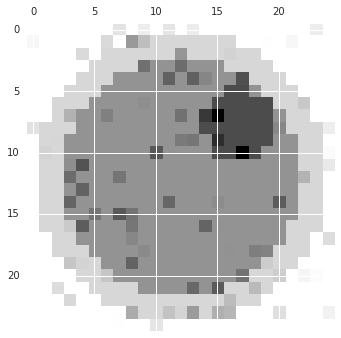

In [12]:
# Make a brain slice.
img = make_synthetic_slice(25, with_tumor=True)
img = add_noise(img, 100, random_state=3234)
X, y = make_X_y(img)
plt.matshow(img)

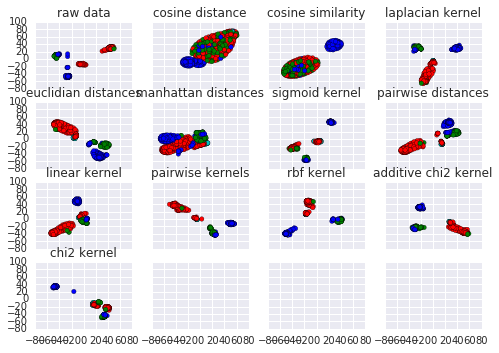

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
for (name, func), ax in zip(pairwise_funcs, axes.flatten()):
    if func is None:
        X_sim = X.copy()  # Just a copy of the raw image values.
    else:
        X_sim = func(X)
    X_tsne = TSNE(perplexity=30, learning_rate=1000.).fit_transform(X_sim)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[y])
    ax.set_title(name)
plt.show()

### Noisier brain

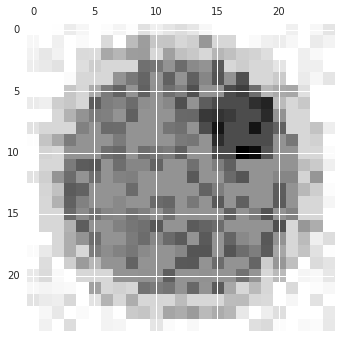

In [14]:
# Make a brain slice.
img = make_synthetic_slice(25, with_tumor=True)
img = add_noise(img, 500, random_state=3234)
X, y = make_X_y(img)
plt.matshow(img)

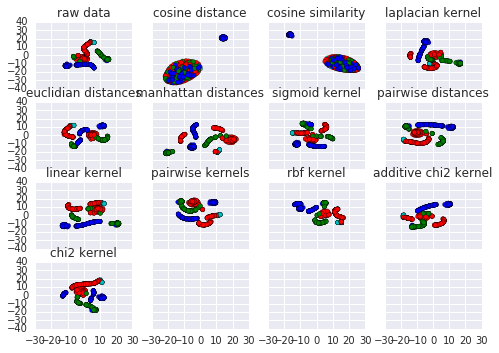

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
for (name, func), ax in zip(pairwise_funcs, axes.flatten()):
    if func is None:
        X_sim = X.copy()  # Just a copy of the raw image values.
    else:
        X_sim = func(X)
    X_tsne = TSNE(perplexity=30, learning_rate=500., n_iter=5000).fit_transform(X_sim)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[y])
    ax.set_title(name)
plt.show()

## Try contrasting tumor and control images

Make 100 images. First 50 have tumor, second 50 do not have tumor.
See how well t-SNE clusters the two types. Each image has a target value.

In [34]:
tumor = [make_synthetic_slice(256, with_tumor=True) for _ in range(50)]
control = [make_synthetic_slice(256, with_tumor=False) for _ in range(50)]
X = np.array(tumor + control)
X = X.reshape(X.shape[0], -1)  # Flatten the images.
y = np.array([1] * 50 + [0] * 50)
print(X.shape, y.shape)

(100, 65536) (100,)


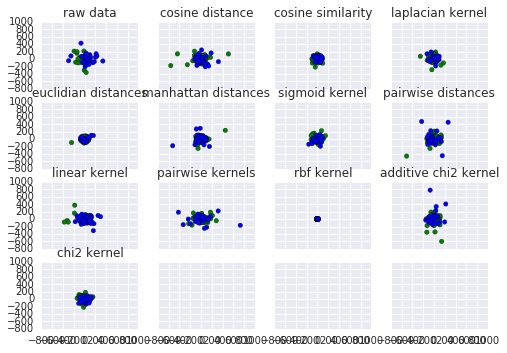

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
for (name, func), ax in zip(pairwise_funcs, axes.flatten()):
    if func is None:
        X_sim = X.copy()  # Just a copy of the raw image values.
    else:
        X_sim = func(X)
    X_tsne = TSNE(perplexity=30, learning_rate=500., n_iter=5000).fit_transform(X_sim)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[y])
    ax.set_title(name)
plt.show()